# Stroke Prediction

### Import Libraries

In [1]:
# Import General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Exploration / Feature Engineering

In [4]:
data.drop('id', axis=1, inplace=True)

In [5]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
len(data)

5110

### BMI (Body Mass Index)
The first feature we will want to explore is the BMI, which is also the only feature with missing data. We will want to asses the missing values and fill them with a determined value, as well as remove any outliers.

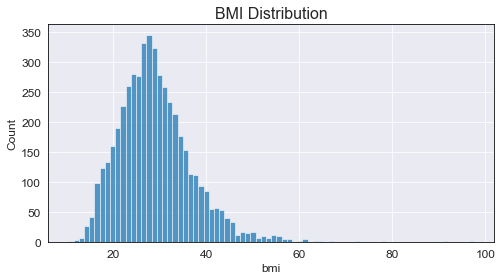

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(x="bmi", data=data)
plt.title('BMI Distribution')
plt.show();

In [9]:
# Fill missing with values with median +/- random noises between [1,3]
error_term = np.round(np.sqrt(np.random.randint(1, 9, size=data.bmi.isna().sum())),2)
bmi_fill = data.bmi.median() + error_term

In [10]:
data.loc[data.bmi.isnull(), 'bmi'] = bmi_fill

In [11]:
# Remove any values above the 99th quantile (approx BMI = 53)
data = data[data.bmi < np.quantile(data.bmi, 0.99)]

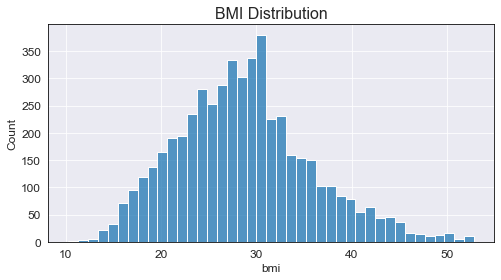

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(x="bmi", data=data)
plt.title('BMI Distribution')
plt.show();

We can see now that the distribution of BMI is much more normally distributed with the majority of observations focused around 29.

#### Weight Class (Feature Engineering)
We will now create 4 new features using the bmi data, based on the [National Heart, Lung, and Blood Institute BMI Scale](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm). Creating these will allow us the asses the weight for each person in the dataset. The link above gives us the following BMI categories:
- Underweight = Less than 18.5
- Normal weight = 18.5 - 24.9
- Overweight = 25 - 29.9
- Obesity = Greater than 30

In [13]:
data['obese'] = np.where(data.bmi >= 30, 1, 0)
data['over_weight'] = np.where(((data.bmi >= 25) & (data.bmi < 30)), 1, 0)
data['normal_weight'] = np.where(((data.bmi >= 18.5) & (data.bmi < 25)), 1, 0)
data['under_weight'] = np.where(data.bmi < 18.5, 1, 0)

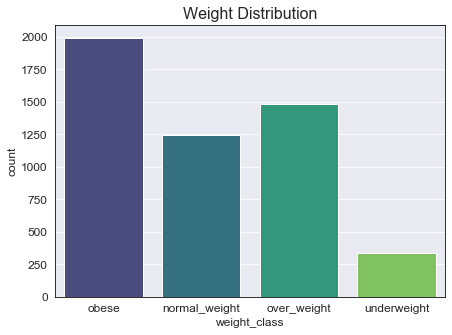

In [64]:
weight_counts = data.iloc[:, -4:].sum()

plt.figure(figsize=(7,5))
sns.countplot(x='weight_class', data=data, palette=sns.color_palette("viridis",4))
plt.title('Weight Distribution')
plt.show();

In [76]:
def weight(row):
    if row['obese'] == 1:
        val = 'obese'
    elif row['over_weight'] == 1:
        val = 'over_weight'
    elif row['normal_weight'] == 1:
        val = 'normal_weight'
    else:
        val = 'underweight'
    return val

data['weight_class'] = data.apply(weight, axis=1)

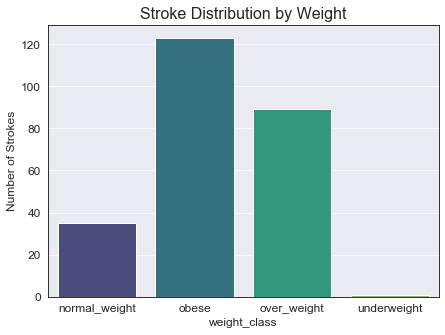

In [77]:
stroke_weight = data.groupby('weight_class').agg('sum')['stroke']

plt.figure(figsize=(7,5))
sns.barplot(x=stroke_weight.index, y=stroke_weight.values, palette=sns.color_palette("viridis",4))
plt.title('Stroke Distribution by Weight')
plt.ylabel('Number of Strokes')
plt.show();

In [78]:
data.drop('weight_class', axis=1, inplace=True) # only needed for graphing

It seems that the majority of the people observed in this dataset were either over weight or obese. Similarly, looking at the occurance of strokes for each class it seems that these two weight classes have the majority of the strokes as well. 

### Smoking Status